In [1]:
import sqlite3
import pandas as pd
import numpy as np
from pandasql import sqldf
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import requests
import sys

In [2]:
conn = sqlite3.connect('database.sqlite')
c = conn.cursor()

In [3]:
c.execute("""SELECT * FROM 
                (SELECT * 
                      FROM Teams_in_Matches  
                      LEFT JOIN Unique_Teams
                      USING(Unique_Team_ID)) tm
                JOIN Matches m
                USING(Match_ID)
                WHERE Season = 2011;
              """)
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]

In [4]:
def gen_goals(df):
    if df.TeamName==df.HomeTeam:
        return df.FTHG
    else:
        return df.FTAG

In [5]:
df['goals'] = df.apply(lambda x: gen_goals(x), axis=1)

In [6]:
def gen_wins(df):
    if df.TeamName==df.HomeTeam:
        if df.FTR=='H':
            return 1
        elif df.FTR=='A':
            return 0
        elif df.FTR=='D':
            return np.NaN
    elif df.TeamName==df.AwayTeam:
        if df.FTR=='H':
            return 0
        elif df.FTR=='A':
            return 1
        elif df.FTR=='D':
            return np.NaN

In [7]:
df['wins'] = df.apply(lambda x: gen_wins(x), axis=1)

In [8]:
pysqldf = lambda q: sqldf(q, globals())

In [28]:
q = """SELECT Unique_Team_ID, TeamName, SUM(goals) as Total_Goals, SUM(wins) as Total_Wins
        FROM df
        GROUP BY TeamName;"""

In [29]:
results = pysqldf(q)

In [30]:
def create_hist(df, ID):
    df2 = df[df['Unique_Team_ID']==ID]
    plt.title("{}'s Wins and Losses".format(df2.TeamName.iloc[0]))
    plt.xlabel('Losses                                                                               Wins')
    df2['wins'].hist()
    plt.show()

In [31]:
results['histogram'] = create_hist

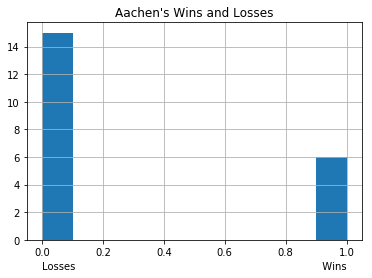

In [32]:
results.loc[0, 'histogram'](df, results.loc[0]['Unique_Team_ID'])

In [33]:
results.head()

,Unique_Team_ID,TeamName,Total_Goals,Total_Wins,histogram
0,34,Aachen,30,6.0,<function create_hist at 0x1a1a3f3b70>
1,81,Arsenal,74,21.0,<function create_hist at 0x1a1a3f3b70>
2,82,Aston Villa,37,7.0,<function create_hist at 0x1a1a3f3b70>
3,15,Augsburg,36,8.0,<function create_hist at 0x1a1a3f3b70>
4,1,Bayern Munich,77,23.0,<function create_hist at 0x1a1a3f3b70>


In [15]:
# imports

## core imports
import sys
import numpy as np
import pandas as pd
import requests

## date time if needed
from datetime import date, timedelta
from datetime import datetime as dt

# database, api & scraping imports
import json
import sqlite3
import pymongo

## visualization imports
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

from darksky_key import *


##--------------------------------------------------
## Classes to manage Dark Sky API requests and responses. 
## THIS IS OVERKILL FOR THIS PROJECT BUT it was interesting.
## Core code was adapted from other projects and a lot of 
## Stack Overflow posts.
##
##--------------------------------------------------

##---------------------------------
## Class to model Dark Sky Data Point Object
## A data point object contains various properties, each representing the average
## (unless otherwise specified) of a particular weather phenomenon occurring during
## a period of time.
##------------------------------------
from builtins import super

class DataPoint():
    """A class to hold Dark Sky API data point objects. A data point object
       contains various properties, each representing the average (unless
       otherwise specified) of a particular weather phenomenon occurring during
       a period of time. Data is in either dictionary or list format.
       Does not manage alerts of flags.
       """
    def __init__(self, data):
        self._data = data

        if isinstance(self._data, dict):
            for name, val in self._data.items():
                setattr(self, name, val)

        if isinstance(self._data, list):
            setattr(self, 'data', self._data)

    def __setattr__(self, name, val):
        def setval(new_val=None):
            return object.__setattr__(self, name, new_val if new_val else val)

        # regular value
        if not isinstance(val, (list, dict)) or name == '_data':
            return setval()

        # data
        if isinstance(val, list):
            val = [DataPoint(v) if isinstance(v, dict) else v for v in val]
            return setval(val)

        # set general data handlers
        setval(DataBlock(val) if 'data' in val.keys() else DataPoint(val))

    def __getitem__(self, key):
        return self._data[key]

    def __len__(self):
        return len(self._data)

##---------------------------------
## A data block object represents the various weather phenomena
## occurring over a period of time. We probably don't need it,
## but...
##------------------------------
class DataBlock(DataPoint):
    """Subclass of DataPoint holds actual raw data from a Dark Sky API request. """
    def __iter__(self):
        return self.data.__iter__()

    def __getitem__(self, index):
        if isinstance(index, str):
            return self._data[index]
        return self.data.__getitem__(index)

    def __len__(self):
        return self.data.__len__()

    
## class to make a forecast or time machine api request to Dark Sky
## if this is instantiated with a time then it makes a time machine request
## no time and it pulls a forecast.
class DarkSky(DataPoint):
    """A class to manage interaction with the Dark Sky API."""

    def __init__(self, key, latitude, longitude, time=None, timeout=None, **queries):
        self._parameters = dict(key=key, latitude=latitude, longitude=longitude, time=time)
        self.refresh(timeout, **queries)

    def __setattr__(self, key, value):
        if key in ('_queries', '_parameters', '_data'):
            return object.__setattr__(self, key, value)
        return super().__setattr__(key, value)

    def __getattr__(self, key):
        currently = object.__getattribute__(self, 'currently')
        _data = object.__getattribute__(currently, '_data')
        if key in _data.keys():
            return _data[key]
        return object.__getattribute__(self, key)

    def __enter__(self):
        return self

    def __exit__(self, type, value, tb):
        del self

    ## decorator to make the url behave like an attribute rather than a method.
    @property
    def url(self):
        time = self._parameters['time']
        timestr = ',{}'.format(time) if time else ''
        uri_format = '{url}/{key}/{latitude},{longitude}{timestr}'
        return uri_format.format(url=_API_URL, timestr=timestr, **self._parameters)

    def refresh(self, timeout=None, **queries):
        self._queries = queries
        self.timeout = timeout
        request_params = {
            'params': self._queries,
            'headers': {'Accept-Encoding': 'gzip'},
            'timeout': timeout
        }

        response = requests.get(self.url, **request_params)
        self.response_headers = response.headers
        if response.status_code is not 200:
            raise requests.exceptions.HTTPError('Bad response')
        return super().__init__(json.loads(response.text))

    
    
## Utility Functions

def dateFromTimeStamp(timestamp):
    year = dt.fromtimestamp(timestamp).year
    month = dt.fromtimestamp(timestamp).month
    day = dt.fromtimestamp(timestamp).day
    datelist = [year, month, day]
    return datelist

def dateFromString(date_string):
    date_list = [int(x) for x in date_string.split('-')]
    t = dt(date_list[0],date_list[1],date_list[2])
    return t    

def getWeather(start, end, duration, city):
    ## Get the start & end dates
    start_date = dateFromString(start)
    end_date = dateFromString(end)
    dur = end_date - start_date
    
    print('Getting weather from', city, 'for dates:', start_date,'-',end_date)
    # dictionary to hold rain data
    rain = {'Date':[], 'Rain': []}
    next_date = start_date
    while next_date<= end_date:
        nextd = next_date.isoformat()
        key_date = next_date.date().isoformat()
        #nextd= nextd.isoformat()  # make it a string
        with DarkSky(ds_key, *city, time=nextd, exclude=['hourly']) as weather:
            
            # get the precipitation for the day
            precip_intensity = weather.daily[0]['precipIntensity']
            if (precip_intensity !=0) and (weather.daily[0]['precipType'] == 'rain'):
                rain['Date'].append(key_date)
                rain['Rain'].append(1)
            else:
                rain['Date'].append(key_date)
                rain['Rain'].append(0)        
        # increment the day
        next_date += timedelta(days=1)
    
    # return the rain dictionary
    
    return rain
    
##----------------------------
##  Constants and Variables
##----------------------------
## URL for Dark Sky API requests
_API_URL = 'https://api.darksky.net/forecast'

# Date endpoints
DURATION = 243 # 243 days total between start and end dates
## Location
## Define BERLIN lat, long
BERLIN = 52.5244, 13.4105

CITY = BERLIN


STARTDATE = '2011-07-15'
ENDDATE =  '2012-05-13'
DURATION = 242


In [16]:
df2 = getWeather(STARTDATE, ENDDATE, DURATION, CITY)

Getting weather from (52.5244, 13.4105) for dates: 2011-07-15 00:00:00 - 2012-05-13 00:00:00


In [17]:
df3 = pd.DataFrame.from_dict(df2)

In [18]:
joined_df = df.set_index('Date').join(df3.set_index('Date'), on='Date')

In [20]:
joined_df.head()

,Match_ID,Unique_Team_ID,TeamName,Div,Season,HomeTeam,AwayTeam,FTHG,FTAG,FTR,goals,wins,Rain
Date,,,,,,,,,,,,,
2012-03-31,1092,1,Bayern Munich,D1,2011,Nurnberg,Bayern Munich,0,1,A,1,1.0,1
2012-03-31,1092,22,Nurnberg,D1,2011,Nurnberg,Bayern Munich,0,1,A,0,0.0,1
2011-12-11,1093,1,Bayern Munich,D1,2011,Stuttgart,Bayern Munich,1,2,A,2,1.0,0
2011-12-11,1093,17,Stuttgart,D1,2011,Stuttgart,Bayern Munich,1,2,A,1,0.0,0
2011-08-13,1094,1,Bayern Munich,D1,2011,Wolfsburg,Bayern Munich,0,1,A,1,1.0,0


In [41]:
q2 = """SELECT Unique_Team_ID, (SUM(wins)/COUNT(Unique_Team_ID)) as Rain_Win_Pct
        FROM joined_df
        WHERE Rain=1
        GROUP BY Unique_Team_ID;"""

In [42]:
results2 = pysqldf(q2)

In [43]:
results2.head()

,Unique_Team_ID,Rain_Win_Pct
0,1,0.727273
1,2,0.600000
2,3,0.428571
3,5,0.500000
4,6,0.727273


In [44]:
final_df = results.set_index('Unique_Team_ID').join(results2.set_index('Unique_Team_ID'), on='Unique_Team_ID')

In [45]:
final_df.head()

,TeamName,Total_Goals,Total_Wins,histogram,Rain_Win_Pct
Unique_Team_ID,,,,,
34,Aachen,30,6.0,<function create_hist at 0x1a1a3f3b70>,0.230769
81,Arsenal,74,21.0,<function create_hist at 0x1a1a3f3b70>,0.571429
82,Aston Villa,37,7.0,<function create_hist at 0x1a1a3f3b70>,0.166667
15,Augsburg,36,8.0,<function create_hist at 0x1a1a3f3b70>,0.363636
1,Bayern Munich,77,23.0,<function create_hist at 0x1a1a3f3b70>,0.727273


In [ ]:
## Write to a Mongo 
to_mdb = df.to_dict(orient='records')
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
newdb = myclient['test_database']
collect = newdb['test_collect']
results = collect.insert_many(to_mdb)
query_1 = collect.find({})
for x in query_1:
   print(x)